# RNN with Custom LSTMCell for japanese character classification

In [1]:
from google.colab import drive, files
import os
drive.mount("/content/gdrive")
%cd gdrive/My Drive/Colab\ Notebooks/
if not os.path.exists('japanese-character-classification'):
    !git clone https://github.com/erikhelmut/japanese-character-classification.git
    %cd japanese-character-classification/notebooks/
else:
    %cd japanese-character-classification/notebooks/
    !git pull
#%pip install -r requirements.txt

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks
Cloning into 'japanese-character-classification'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 531 (delta 77), reused 100 (delta 40), pack-reused 388
Receiving objects: 100% (531/531), 4.15 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (196/196), done.
Checking out files: 100% (162/162), done.
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/notebooks


In [69]:
import time
import math
import random

import sys
import inspect
import os
import glob
import csv

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from src.data.build_features import load_data, file_to_tensor, character_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Vanilla LSTMCell by hand

The repeating module in a LSTM contains four interacting layers. <br>
A full step-by-step walk throuh these layers can be found here: [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

<p style="text-align:center;"><img src="https://github.com/erikhelmut/japanese-character-classification/blob/main/pictures/LSTM3-chain.png?raw=1" width=800 /></p>

Let:

$f_n$ = number of features (input size) <br>
$h_S$ = number of output nodes (hidden size) <br>
$b_S$ = batch size

And then:
- each weight tensor $W_x$ of shape $(f_n, h_S)$
- each weight tensor $W_h$ of shape $(h_S, h_S)$
- each bias tensor $b$ of shape $(1, h_S)$
- input tensor $x_t$ of shape $(b_S, f_n)$, corresponding to the element of index t in each sequence of the batch
- hidden-state tensor $h_t$ of shape $(b_S, h_S)$, corresponding to the element of index t in each sequence of the batch
- with "⋅" representing a matrix multiplication
- and "*" representing a element-wise multiplication

So that the equations of the LSTMCell will be:

<table border="0">
    <tbody>
        <tr>
            <td><b>Forget Gate</b></td>
            <td>$f_t = \sigma\:(W_f\cdot[h_{t-1},\:x_t] + b_f) = \sigma\:(x_t \cdot W_{xf} + h_{t-1} \cdot W_{hf} + b_f)$</td>
        </tr>
        <tr>
            <td><b>Input Gate</b></td>
            <td>$i_t = \sigma\:(W_i\cdot[h_{t-1},\:x_t] + b_i) = \sigma\:(x_t \cdot W_{xi} + h_{t-1} \cdot W_{hi} + b_i)$</td>
        </tr>
        <tr>
            <td><b>Candidate Values</b></td>
            <td>$\tilde{C_t}\:(=g_t) = \tanh(W_C\cdot[h_{t-1},\:x_t] + b_C) = \tanh(x_t \cdot W_{xC} + h_{t-1} \cdot W_{hC} + b_C)$</td>
        </tr>
        <tr>
            <td><b>Cell State</b></td>
            <td>$C_t = f_t*C_{t-1} + i_t*\tilde{C_t}$</td>
        </tr>
        <tr>
            <td><b>Output</b></td>
            <td>$o_t = \sigma\:(W_o\cdot[h_{t-1},\:x_t] + b_o) = \sigma\:(x_t \cdot W_{xo} + h_{t-1} \cdot W_{ho} + b_o)$</td>
        </tr>
        <tr>
            <td><b>Hidden State</b></td>
            <td>$h_t = o_t*\tanh(C_t)$</td>
        </tr>
    </tbody>
</table>

In [70]:
class VanillaLSTMCell(nn.Module):
    
    def __init__(self, input_size: int, hidden_size: int):
        super(VanillaLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # forget gate: f_t
        self.W_xf = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        
        # input gate: i_t
        self.W_xi = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))
        
        # candidate values: g_t
        self.W_xC = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hC = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_C = nn.Parameter(torch.Tensor(hidden_size))
        
        # cell state: C_t
        
        # output: o_t
        self.W_xo = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))
        
        # hidden state: h_t
        
        self.init_weights()
        
    def forward(self, x, init_states=None):
        
        """
        forward() -> List, Tupel(Tensor, Tensor)

        Returns a list filled with all hidden_states.
            Returns a tupel which includes the current hidden- and cell-state.

        Keywords:
            x - input-tensor of shape (seq_len, batch, hidden_size).
            init_states - tuple which includes initial hidden- and cell-state.
        """
        
        seq_len, batch, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, C_t = (torch.zeros(batch, self.hidden_size).to(device), torch.zeros(batch, self.hidden_size).to(device))
        else:
            h_t, C_t = init_states
            
        for t in range(seq_len):
            # input-tensor of shape (batch, input_size)
            x_t = (x[t])
            
            # forget gate
            f_t = torch.sigmoid(x_t @ self.W_xf + h_t @ self.W_hf + self.b_f)
            
            # input gate
            i_t = torch.sigmoid(x_t @ self.W_xi + h_t @ self.W_hi + self.b_i)
            
            # candidate values
            g_t = torch.tanh(x_t @ self.W_xC + h_t @ self.W_hC + self.b_C)
            
            # cell state
            C_t = f_t * C_t + i_t * g_t
            
            # output
            o_t = torch.sigmoid(x_t @ self.W_xo + h_t @ self.W_ho + self.b_o)
            
            # hidden state
            h_t = o_t * torch.tanh(C_t)
            
            # append hidden_seq with h_t of shape (batch, hidden_size)
            hidden_seq.append(h_t.unsqueeze(0))
            
        # reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        
        return hidden_seq, (h_t, C_t)
                            
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            # apply uniform distribution to the weights
            weight.data.uniform_(-stdv, stdv)

## Optimized Vanilla LSTMCell by hand

The "VanillaLSTMCell"-Class is not optimized in terms of computational time. <br>
Performing 8 matrix multiplications separately cause an enormously high time to perform. <br>
In order to avoid this much computational time, the "OptimizedVanillaLSTMCell"-Class will perform these computation in a vectorized way. 

To achive this operation, two matrixes, $W_x$ and $W_h$, are set up, which have the weight contained on the 4 matrix multiplications each of they do. <br>
The gated operations will be performed on the matrixes that already passed per the linear combinations + bias operation.

For a more detailed explanation: [Building a LSTM by hand on PyTorch](https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091)

Let again:

$f_n$ = number of features (input size) <br>
$h_S$ = number of output nodes (hidden size) <br>
$b_S$ = batch size

And then:
- weight tensor $W_x$ of shape $(f_n, h_S*4)$
- weight tensor $W_h$ of shape $(h_S, h_S*4)$
- bias tensor $b$ of shape $(1, h_S*4)$
- input tensor $x_t$ of shape $(b_S, f_n)$, corresponding to the element of index t in each sequence of the batch
- hidden-state tensor $h_t$ of shape $(b_S, h_S)$, corresponding to the element of index t in each sequence of the batch
- with "⋅" representing a matrix multiplication
- and "*" representing a element-wise multiplication
- $T[x,y]$ indicates the element of the tensor $T$ at the coordinates $(x,y)$
- $T[x,:]$ indicates the $x_{th}$ row of the tensor $T$
- $T[:,y]$ incicates the $y_{th}$ column of the tensor $T$
- $T[:,y:y_n]$ indictaes the subtensor of $T$ that corresponds all of its rows and columns $y$ to $y_n$

With the vectorized operations, the equations of the LSTMCell would be:

<table border="0">
    <tbody>
        <tr>
            <td><b>"Concatenated gates matrix"</b></td>
            <td>$A_t = x_t\cdot W_x + h_t\cdot W_h + b$</td>
        </tr>
        <tr>
            <td><b>Forget Gate</b></td>
            <td>$f_t = \sigma\:(A_t[:,\:h_S:(h_S*2)])$</td>
        </tr>
        <tr>
            <td><b>Input Gate</b></td>
            <td>$i_t = \sigma\:(A_t[:,\:0:h_S])$</td>
        </tr>
        <tr>
            <td><b>Candidate Values</b></td>
            <td>$\tilde{C_t}\:(=g_t) = \tanh(A_t[:,\:(h_S*2):(h_S*3)])$</td>
        </tr>
        <tr>
            <td><b>Cell State</b></td>
            <td>$C_t = f_t*C_{t-1} + i_t*\tilde{C_t}$</td>
        </tr>
        <tr>
            <td><b>Output</b></td>
            <td>$o_t = \sigma\:(A_t[:,\:(h_S*3):(h_S*4)])$</td>
        </tr>
        <tr>
            <td><b>Hidden State</b></td>
            <td>$h_t = o_t*\tanh(C_t)$</td>
        </tr>
    </tbody>
</table>

### LSTMCell with peephole connections

One popular LSTM variation, introduced by [[Gers und Schmidhuber, 2000]](https://ieeexplore.ieee.org/document/861302), is adding so-called "peephole connections". In this case the gate layers are able to look at the cell state.

<p style="text-align:center;"><img src="https://github.com/erikhelmut/japanese-character-classification/blob/main/pictures/LSTM3-var-peepholes.png?raw=1" width=400/></p>

In this case, with the vectorized operations, the equations of the LSTMCell with peephole connections would be:

<table border="0">
    <tbody>
        <tr>
            <td><b>"Concatenated gates matrix"</b></td>
            <td>$A_t = x_t\cdot W_x + h_t\cdot W_h + b$</td>
        </tr>
        <tr>
            <td><b>Forget Gate</b></td>
            <td>$f_t = \sigma\:(A_t[:,\:h_S:(h_S*2)])$</td>
        </tr>
        <tr>
            <td><b>Input Gate</b></td>
            <td>$i_t = \sigma\:(A_t[:,\:0:h_S])$</td>
        </tr>
        <tr>
            <td><b>Cell State</b></td>
            <td>$C_t = f_t*C_{t-1} + i_t*\sigma\:(x_t\cdot W_x + b)[:,\:(h_S*2):(h_S*3)]$</td>
        </tr>
        <tr>
            <td><b>Output</b></td>
            <td>$o_t = \sigma\:(A_t[:,\:(h_S*3):(h_S*4)])$</td>
        </tr>
        <tr>
            <td><b>Hidden State</b></td>
            <td>$h_t = o_t*\tanh(C_t)$</td>
        </tr>
    </tbody>
</table>

In [71]:
class OptimizedPeepholeLSTMCell(nn.Module):
    
    def __init__(self, input_size: int, hidden_size: int, peephole=False):
        super(OptimizedPeepholeLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.peephole = peephole
        
        # weight tensor W_x
        self.W_x = nn.Parameter(torch.Tensor(input_size, hidden_size*4))
        
        # weight tensor W_h
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size*4))
        
        # bias tensor
        self.b = nn.Parameter(torch.Tensor(hidden_size*4))
        
        self.init_weights()
        
    def forward(self, x, init_states=None):
        
        """
        forward() -> List, Tupel(Tensor, Tensor)

        Returns a list filled with all hidden_states.
            Returns a tupel which includes the current hidden- and cell-state.

        Keywords:
            x - input-tensor of shape (seq_len, batch, hidden_size).
            init_states - tuple which includes initial hidden- and cell-state.
        """
        
        seq_len, batch, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, C_t = (torch.zeros(batch, self.hidden_size).to(device), torch.zeros(batch, self.hidden_size).to(device))
        else:
            h_t, C_t = init_states
            
        hS = self.hidden_size    
            
        for t in range(seq_len):
            # input-tensor of shape (batch, input_size)
            x_t = (x[t])
            
            # batch the computation into a single tensor multiplication
            if self.peephole:
                gates = x_t @ self.W_x + h_t @ self.W_h + self.b
            else:
                gates = x_t @ self.W_x + h_t @ self.W_h + self.b
                g_t = torch.tanh(gates[:, hS*2:hS*3]) # candidate values
            
            f_t, i_t, o_t = (
                torch.sigmoid(gates[:, hS:hS*2]), # forget gate
                torch.sigmoid(gates[:, :hS]), # input gate
                torch.sigmoid(gates[:, hS*3:]) # output
            )
            
            if self.peephole:
                # cell state
                C_t = f_t * C_t + i_t * torch.sigmoid(x_t @ self.W_x + self.b)[:, hS*2:hS*3]
                # hidden state
                h_t = o_t * torch.tanh(C_t)
            else:
                # cell state
                C_t = f_t * C_t + i_t * g_t
                # hidden state
                h_t = o_t * torch.tanh(C_t)
            
            # append hidden_seq with h_t of shape (batch, hidden_size)
            hidden_seq.append(h_t.unsqueeze(0))
            
        # reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        
        return hidden_seq, (h_t, C_t)
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            # apply uniform distribution to the weights
            weight.data.uniform_(-stdv, stdv)

## Defining network structure

In [72]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_characters):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstmcell = VanillaLSTMCell(input_size, hidden_size)
        #self.lstmcell = OptimizedPeepholeLSTMCell(input_size, hidden_size, peephole=True)

        self.fc = nn.Linear(hidden_size, n_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(x.size(1), self.hidden_size).to(device)
        
        # output of shape (seq_len, batch, n_directions * hidden_size)
        _, hc = self.lstmcell(x, (h0,c0))
        h1 = hc[0]
        c1 = hc[1]
        
        out = self.fc(h1)
        out = self.softmax(out)

        return out

## Define helper functions for neural network's training

In [73]:
def train(file_tensor, character_tensor):
    output = model(file_tensor)
    loss = criterion(output, character_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

## Defining hyperparameters of neural network's training

In [74]:
# load train dataset
character_files, all_characters = load_data(path="../data/train/")

# hyper parameters
input_size = 3 # features: x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128
n_layers = 1

learning_rate = 0.005

## Start training loop

In [32]:
# initialize neural network   
model = RNN(input_size, hidden_size, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

print_every = 5#5000
plot_every = 100#1000
n_iters = 10000#50000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5 0% (0m 1s) 1.5308 ../data/train\i__07498.csv / i ✓
10 0% (0m 2s) 1.5728 ../data/train\e__49604.csv / i ✗ (e)
15 0% (0m 3s) 1.5804 ../data/train\i__39419.csv / a ✗ (i)
20 0% (0m 4s) 1.5775 ../data/train\e__12853.csv / i ✗ (e)
25 0% (0m 5s) 1.7341 ../data/train\o__49156.csv / a ✗ (o)
30 0% (0m 7s) 1.7332 ../data/train\o__31750.csv / e ✗ (o)
35 0% (0m 8s) 1.5083 ../data/train\e__06730.csv / e ✓
40 0% (0m 9s) 1.5232 ../data/train\a__29661.csv / e ✗ (a)
45 0% (0m 10s) 1.6347 ../data/train\i__22628.csv / e ✗ (i)
50 0% (0m 11s) 1.5955 ../data/train\i__92051.csv / e ✗ (i)


KeyboardInterrupt: 

## Plot LOSS-function

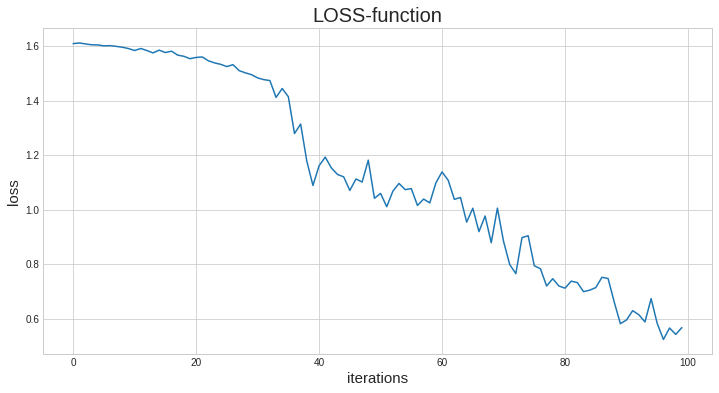

In [33]:
# create figure
mpl.style.use("seaborn") #seaborn-whitegrid
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS-function", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [30]:
%cd ../models/
FILE = "2.4-lstm-cell-network-byhand-model.pth"
torch.save(model.state_dict(), FILE)
%cd ../notebooks/

/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/models
/content/gdrive/My Drive/Colab Notebooks/japanese-character-classification/notebooks


## Load model

In [75]:
%cd ../models/
FILE = "2.4-lstm-cell-network-byhand-model.pth"
loaded_model = RNN(input_size, hidden_size, n_characters).to(device)
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
loaded_model.eval()
%cd ../notebooks/

C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\models
C:\Users\erikh\OneDrive\Dokumente\Studium\!Studienarbeit\japanese-character-classification\notebooks


## Determine accuracy

characters in test data:  ['a', 'e', 'i', 'o', 'u']
../data/test\a__88470.csv / a ✓
../data/test\a__94789.csv / a ✓
../data/test\a__96486.csv / a ✓
../data/test\a__97545.csv / a ✓
../data/test\a__98539.csv / a ✓
../data/test\e__70433.csv / e ✓
../data/test\e__76682.csv / e ✓
../data/test\e__82254.csv / e ✓
../data/test\e__83191.csv / e ✓
../data/test\e__84585.csv / e ✓
../data/test\i__75461.csv / i ✓
../data/test\i__81833.csv / i ✓
../data/test\i__88644.csv / i ✓
../data/test\i__89095.csv / i ✓
../data/test\i__91889.csv / i ✓
../data/test\o__54903.csv / u ✗ (o)
../data/test\o__63253.csv / a ✗ (o)
../data/test\o__67824.csv / o ✓
../data/test\o__72419.csv / u ✗ (o)
../data/test\o__76748.csv / u ✗ (o)
../data/test\u__81848.csv / u ✓
../data/test\u__82120.csv / u ✓
../data/test\u__83897.csv / u ✓
../data/test\u__85976.csv / u ✓
../data/test\u__88458.csv / u ✓
../data/test\u__93521.csv / u ✓

accuracy = 84.62 %



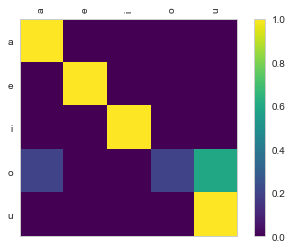

In [76]:
# load test dataset
character_files, all_characters = load_data(path="../data/test/")
print("characters in test data: ", all_characters)

# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_characters, n_characters)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for character in all_characters:
        # all files from one character
        for file in character_files[character]:
            file_tensor = file_to_tensor(file).to(device)
            # get output
            output = loaded_model(file_tensor).to(device)
            # get character from output
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
                correct = "✓"
            else:
                correct = "✗ (%s)" % character
            confusion[all_characters.index(character)][all_characters.index(guess)] += 1
            
            print(file, "/", guess, correct)

# normalize by dividing every row by its sum
for i in range(n_characters):
    confusion[i] = confusion[i] / confusion[i].sum()

acc = 100.0 * n_correct / n_samples
print(f"\naccuracy = {acc:.2f} %\n")

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(False)
cax = ax.matshow(confusion.numpy(), cmap="viridis")
fig.colorbar(cax)

# set up axes
ax.set_xticks(range(5))
ax.set_yticks(range(5))
ax.set_xticklabels(all_characters, rotation=90)
ax.set_yticklabels(all_characters)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()